# Satellite Image Classification Project
## Project Overview
This script build and validate a classification model using satellite image data.
## Introduction
There are three different classification models applied:
1. Random Forest
2. Extra Tree
3. Bagging

Performance of each  model will be assesed visually by confusion matrix. Further preformance report is printed followed by Kohen Kappa Score values.
## Approach
The analysis were carried out in the following steps:
1. Data from file „labels.csv” was read
2. Labels was numbered from 0 to 9 to create vector for classification
3. Columns: *x*, *y*, *band1*, *band2*, *band3*, *band4*, *band5*, *band6* was used as samples to train and test each of the models; total size of samples and split to train / test data is reported in appendices
4. Confusion matrices are calculated and presented in plots (see Figure 1÷3)
5. Train samples was fit to each classification model and metrics such as precision, recall for ech category/label and average accuracy as well as macro and weighted average of all categories are reported in appendices
6. Cohen kappa score was calculated from prediction and test data to asses accuracy for selection the best fitted classification model
7. File „satellite_image.csv” including satellite image (coordinates and eight bands) was read and all columns were applied to prediction models
8. Satellite image was plotted in new coordinate system with color brightness read form band4 (red), band3 (green) and band2 (blue) - origin of original coordinate system was set to 0,0 (see Figure 4)
9. On the top of plotted satellite image the categories/labels as points was overlaid; color scheme was selected the same like for predicted land cover maps
10. Each category was designated by color and predicted categories for each pixel were plotted as a land cover map (see Figures 5÷7)


In [1]:
%matplotlib inline

## Python modules in use
To build and validate model performance some libraries were necessary. Version of libriaries working with this scirpt are included in *requirements.txt* [file](https://github.com/pciuh/satellite-image-classification/blob/main/requirements.txt)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate as sci
import seaborn as sns

from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score

## Function for plotting a confusion matrix

In [3]:
def ploconfmat(clf_cfm,lbl,TIT,SUF):
    fig,ax = plt.subplots(1,figsize=(7,7))
    gc = ["{0:0.0f}".format(x) for x in clf_cfm.flatten()]

    gp = ["{0:.1%}".format(x) for x in
                         clf_cfm.flatten()/np.sum(clf_cfm)]

    labels = [f"{v1}\n{v2}\n" for v1, v2 in
              zip(gc,gp)]

    labels = np.asarray(labels).reshape(len(lbl),len(lbl))

    ax = sns.heatmap(clf_cfm, annot=labels,fmt='',cmap='Blues',cbar_kws={"shrink": 0.75})
    
    ax.set_title('Confusion Matrix ('+TIT+')\n\n');
    ax.set_xlabel('\nPredicted Labels Category')
    ax.set_ylabel('Actual Labels Category ');
    ax.xaxis.set_ticklabels(lbl)
    ax.yaxis.set_ticklabels(lbl)
    fig.tight_layout()
    fig.savefig('plots/conf_mat-'+SUF+'.pdf',dpi=300)


## Function for plotting satellite image and features

In [4]:
def plosat(df,data,im_ext,marker,label,color):
    ##### Variables description
    #####
    #####     df: features -> pandas DataFrame
    #####   data: array of colors for imshow (403x449) per each pixel -> numpy array, array shape: nx_pix=403,ny_pix=449,n_col=3
    ##### im_ext: tuple of image extent (xMin,xMax,yMin,yMax) -> tuple
    ##### marker: individual marker definition -> list of strings
    #####  label: individual label names -> list of labels

    fig,ax = plt.subplots(1,figsize=(7,7))
    
    ax.set_title('Satellite Image with Features')
    
    ax.imshow(data,origin='lower',extent=im_ext)
    
    for i,l in enumerate(label):
        xl,yl = (df.x[df.label==l]-xMin,df.y[df.label==l]-yMin)
        ax.scatter(xl,yl,color=color[i],marker=marker[i],label=label[i],alpha=1.0)

    ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
    ax.axis('off')
    ax.set_aspect(1)
    fig.savefig('plots/satellite-image.png',dpi=300, bbox_inches='tight')

In [5]:
def plopred(label,idx,coor,color,ModelName,SUF):

    handles = [
                Patch(facecolor=color, label=label) 
                for label, color in zip(label, color)
                ]
    
    fig,ax = plt.subplots(1,figsize=(7,7))
    ax.set_title('Model: '+ModelName)
    
    xr,yr = coor
    for i,l in enumerate(lbl):
        ax.scatter(xr[idx==i],yr[idx==i],color=color[i],marker='.',s=1,label=label[i])

    ax.axis('off')
    ax.set_aspect(1)
    ax.legend(handles = handles, loc='center left',bbox_to_anchor=(1.0, 0.5))
    fig.savefig('plots/pred-'+SUF+'.png',dpi=300, bbox_inches='tight')



## Reading files for classification

File *labels.csv* is read to pandas DataFrame object. File include *band* features numbered from *1* to *6*.

In [6]:
SEED = 30082024

iDir = 'input/'

fnam = 'labels.csv'
df = pd.read_csv(iDir + fnam,sep=',')
lbl = df.label.drop_duplicates().values
print('Labels:',lbl)

fnam = 'satellite_image.csv'
dfs = pd.read_csv(iDir + fnam,sep=',')

Labels: ['road1' 'road2' 'grass' 'water' 'roof1' 'roof2' 'roof3' 'tree' 'shadow'
 'soil']


In [7]:
_,num = np.unique(df.label,return_counts=True) ### Count number of labels
variables = df.drop(['label','band7','band8'],axis=1).columns.values
print('Features:',variables)

Features: ['x' 'y' 'band1' 'band2' 'band3' 'band4' 'band5' 'band6']


All above variables are to be features of classification model and assigned to the matix *X*. Values for further prediction of identified features are assigned to matrix *X_feat*.

In [8]:
X = df[variables].values
X_feat = dfs[variables].values

The output vector *y* will be built on *lbl* variable from imported database. Below part of code assign integer numbers for each label.

In [9]:
y = []
for i,l in enumerate(lbl):
    for ni in range(num[i]):
        y=np.append(y,i)

In [10]:
TIT = {'RF' : 'Random Forest', 'ET' : 'Extra Tree', 'BA' : 'Bagging'}

mvec = [ExtraTreesClassifier(),
        RandomForestClassifier(),
        BaggingClassifier()]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state = SEED)
#print('Total Size:',X.shape,y.shape)
#print('Train Size:',X_train.shape, y_train.shape)
#print(' Test Size:',X_test.shape, y_test.shape)

In [11]:
pvec,fvec = [],[]
for v in mvec:
    v.fit(X_train, y_train)
    pvec.append(v.predict(X_test))
    fvec.append(v.predict(X_feat))

In [12]:
ofnam = 'class_report-%.8d.txt'%SEED
of = open(ofnam,'w')
of.write('            %10s%10s%10s\n'%('Samples','Category','Outcome'))
of.write('Total Size: %10.0f%10.0f%10.0f\n'%(X.shape[0],X.shape[1],y.shape[0]))
of.write('Train Size: %10.0f%10.0f%10.0f\n'%(X_train.shape[0],X_train.shape[1],y_train.shape[0]))
of.write(' Test Size: %10.0f%10.0f%10.0f\n'%(X_test.shape[0],X_test.shape[1],y_test.shape[0]))

p_crf,p_cet,p_cba = pvec
mNam = ['RF','ET','BA']

of.write('\n%36s\n'%'Model Performace')
print('\nModel Performance')


Model Performance


## Performance analysis report and confusion matrix

In [13]:
cfm = []
for i,v in enumerate(pvec):
    cks = cohen_kappa_score(y_test,v)
    cre = classification_report(y_test, v, target_names=lbl,zero_division=0.0)
    print('\n%18s:'%TIT[mNam[i]])
    print(cre)
    #print('Kappa Score:',cks)

    of.write('\n%14s:\n'%TIT[mNam[i]])
    of.write(cre)
    #of.write('\nKappa Score:%12.3f\n'%(cks)) 

    cfm.append(confusion_matrix(y_test, v))
of.close()


     Random Forest:
              precision    recall  f1-score   support

       road1       0.50      0.50      0.50         2
       road2       0.75      1.00      0.86         3
       grass       1.00      0.50      0.67         4
       water       1.00      1.00      1.00         1
       roof1       1.00      0.50      0.67         2
       roof2       0.50      0.50      0.50         2
       roof3       1.00      1.00      1.00         2
        tree       0.75      1.00      0.86         6
      shadow       0.60      0.43      0.50         7
        soil       0.20      0.33      0.25         3

    accuracy                           0.66        32
   macro avg       0.73      0.68      0.68        32
weighted avg       0.70      0.66      0.66        32


        Extra Tree:
              precision    recall  f1-score   support

       road1       1.00      1.00      1.00         2
       road2       1.00      1.00      1.00         3
       grass       0.75      0.75   

## Data visualization

### Plotting confusion matrix

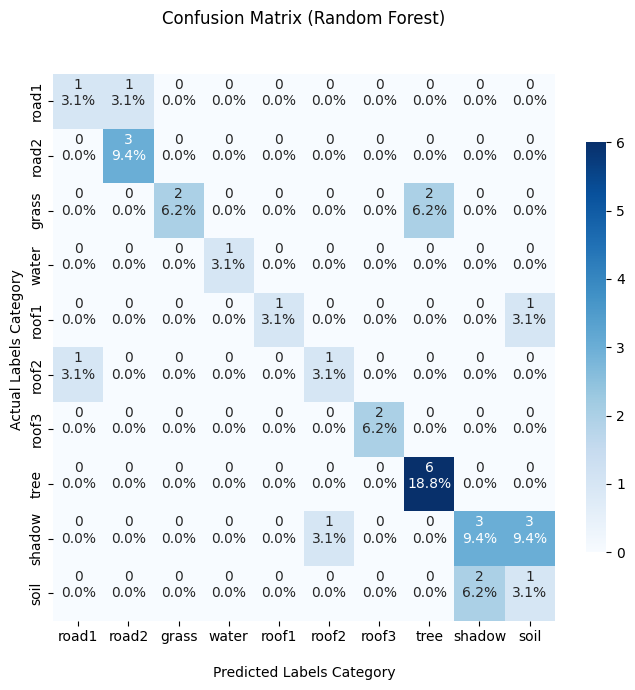

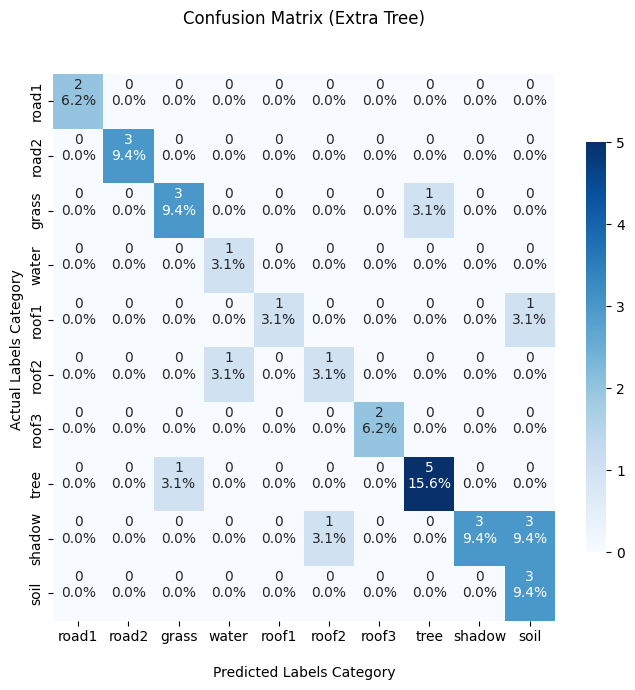

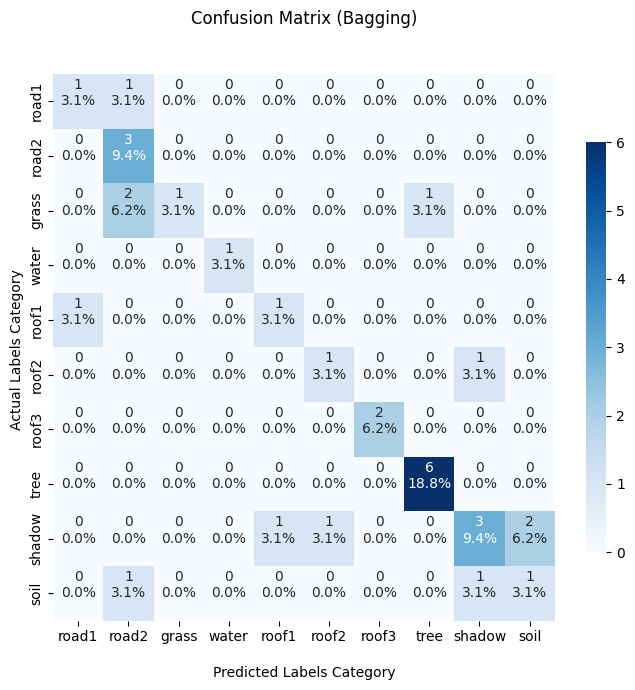

In [14]:
for i,c in enumerate(cfm):
    ploconfmat(c,lbl,TIT[mNam[i]],mNam[i])

### Plotting satelite image with identified features

/usr/local/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


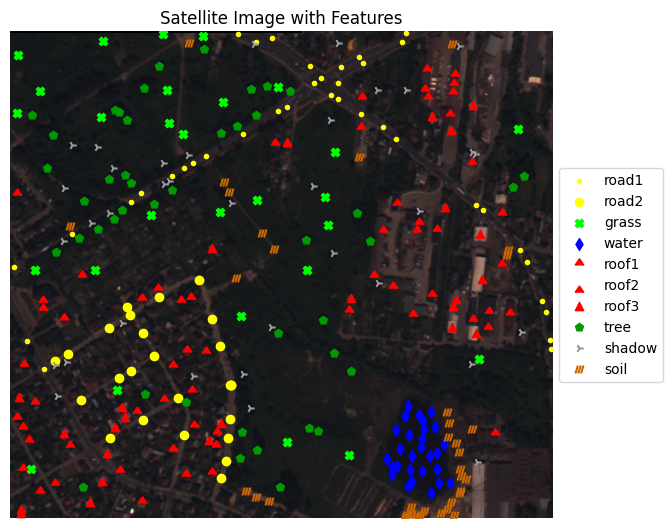

In [15]:
xMin = min(dfs.x)
yMin = min(dfs.y)

xr,yr = (dfs.x-xMin,dfs.y-yMin)

rr = dfs.band4/max(dfs.band4)
rg = dfs.band3/max(dfs.band3)
rb = dfs.band2/max(dfs.band2)

_,num = np.unique(yr.values,return_counts=True)
Nx = num[0]
Ny = int(xr.shape[0]/num[0])

xg,yg = np.meshgrid(np.linspace(min(xr),max(xr),Nx),np.linspace(min(yr),max(yr),Ny))

rrg = sci.griddata((xr,yr),rr,(xg,yg))
rgg = sci.griddata((xr,yr),rg,(xg,yg))
rbg = sci.griddata((xr,yr),rb,(xg,yg))

data   = np.dstack((rrg,rgg,rbg))
im_ext = (min(xr),max(xr),min(yr),max(yr))
marker = ['.','o','X','d',10,6,'^','p','4','$///$']
color  = np.array(
       [[1.0,1.0,0.0,1.0],
        [1.0,1.0,0.0,1.0],
        [0.0,1.0,0.0,1.0],
        [0.0,0.0,1.0,1.0],
        [1.0,0.0,0.0,1.0],
        [1.0,0.0,0.0,1.0],
        [1.0,0.0,0.0,1.0],
        [0.0,0.6,0.0,1.0],
        [0.6,0.6,0.6,1.0],
        [0.8,0.4,0.0,1.0]]) 

plosat(df,data,im_ext,marker,lbl,color)

### Ploting satellite image with predicted labels

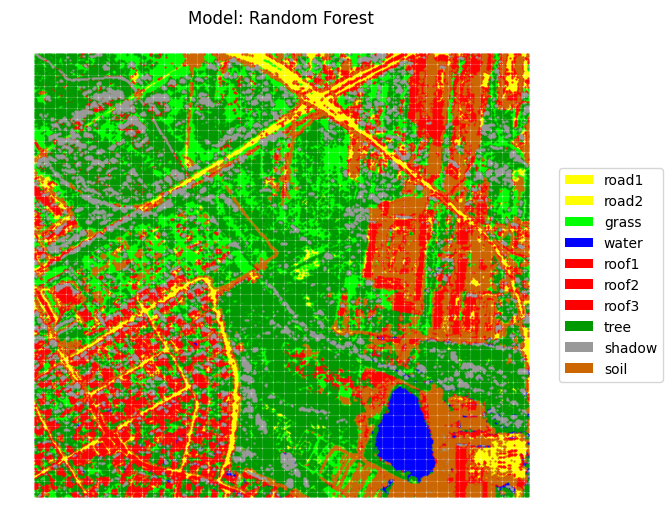

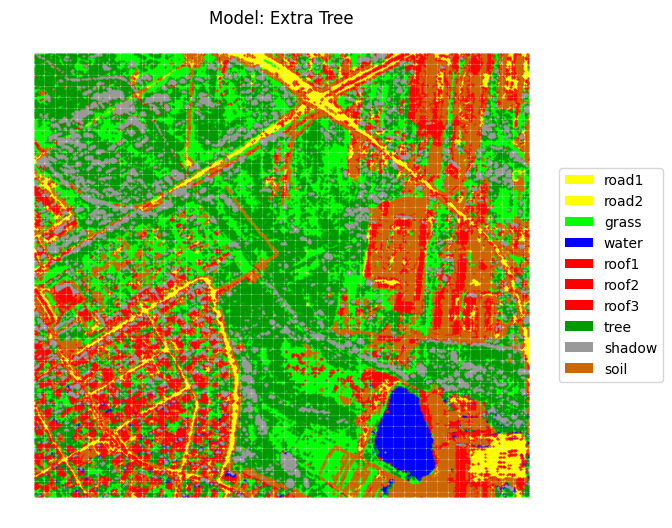

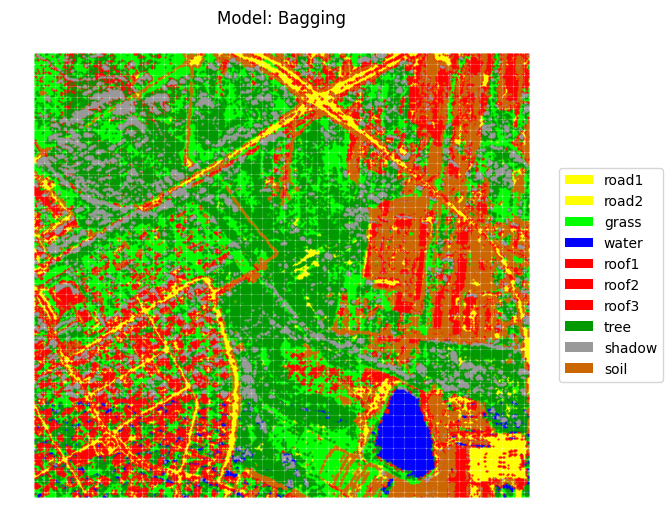

In [16]:
for i,v in enumerate(fvec):
    plopred(lbl,v,(xr,yr),color,TIT[mNam[i]],mNam[i])